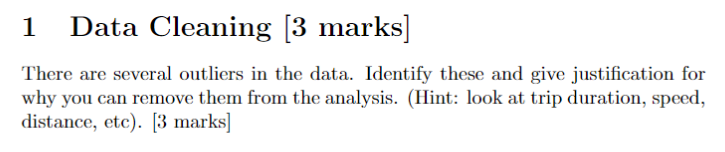

In [44]:
#Pandas
import pandas as pd
#Numpy
import numpy as np
#Folium
import folium
#Fiona
import fiona
#Shapely
import shapely
#Geopandas
import geopandas as gpd
#Sklearn cluster dbscan
from sklearn.cluster import DBSCAN
#Matplotlib
import matplotlib.pyplot as plt

In [45]:
# Load dataset
df = pd.read_csv('nyc_taxis/nyc_taxis.csv')

In [46]:
# Convert datetime columns to datetime type
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

In [47]:
# Calculate trip duration in minutes
df['trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60

In [48]:
# Remove trips with zero or negative duration
df = df[df['trip_duration'] > 0]

In [49]:
# Calculate the Haversine distance between pickup and dropoff locations
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [50]:
# Apply the haversine function to each row
df['trip_distance'] = df.apply(lambda row: haversine(row['pickup_longitude'], row['pickup_latitude'], 
                                                     row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

In [51]:
# Remove trips with zero distance
df = df[df['trip_distance'] > 0]

In [52]:
# Calculate average speed (km/h)
df['avg_speed'] = (df['trip_distance'] / (df['trip_duration'] / 60))

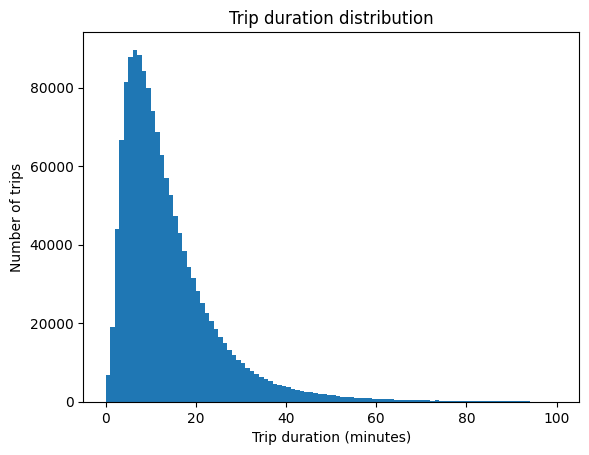

In [53]:
# Plot the trip duration, so we can see the distribution, also have a threshold of 1000 minutes
df['trip_duration'].plot(kind='hist', bins=100, range=(0, 100))
plt.xlabel('Trip duration (minutes)')
plt.ylabel('Number of trips')
plt.title('Trip duration distribution')
plt.show()

The histogram shows the distribution of trip durations. It is heavily right-skewed, meaning most of the trips are short, with the majority under 50 minutes, and a long tail representing trips with longer durations. Given this, we can make decisions on how to clean the data:

Justification for Data Cleaning
Trip Duration:

The plot shows that the majority of trips last under 50 minutes. Extremely long trips could be considered outliers because they deviate significantly from the bulk of the data.
Based on this distribution, we can remove trips with a duration exceeding 120 minutes (2 hours) as these are likely outliers and not representative of typical NYC taxi rides.
We should also remove trips with extremely short durations, such as trips lasting less than 1 minute, as they might represent errors in the data or cases where the trip was immediately canceled.
Distance:

Although not directly shown in this plot, we can assume that trips with a very small or zero distance (e.g., under 100 meters) are also erroneous and should be removed.
Speed:

After calculating the average speed of each trip, trips with unrealistic speeds, such as over 100 km/h or below 1 km/h, should be filtered out, as such speeds are unlikely for urban trips in NYC.

In [54]:
# Identify outliers based on trip duration, distance, and average speed
# Trip duration threshold (e.g., above 2 hours or below 1 minute)
df = df[(df['trip_duration'] < 120) & (df['trip_duration'] > 1)]

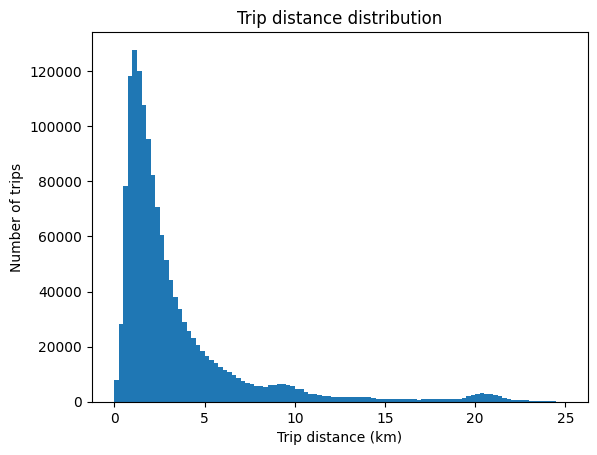

In [55]:
# Plot the trip distance, so we can see the distribution, also have a threshold
df['trip_distance'].plot(kind='hist', bins=100, range=(0, 25))
plt.xlabel('Trip distance (km)')
plt.ylabel('Number of trips')
plt.title('Trip distance distribution')
plt.show()

The histogram represents the trip distance distribution, which shows that the majority of trips are short distances (most are under 20 km), and the distribution is again right-skewed with a long tail. Let’s combine the insights from both the trip duration and trip distance histograms to refine the data cleaning strategy:

Justification for Cleaning with Trip Distance:
Trip Distance:

Similar to the trip duration distribution, this histogram indicates that most trips fall under 20 km, with a small percentage of trips extending beyond this.
We see an especially sharp spike at near-zero distances. These near-zero trips likely represent errors, or cases where the trip was canceled or incomplete. Removing trips with extremely short distances (e.g., under 100 meters) is reasonable, as they are likely erroneous.
Trips with extreme distances (e.g., beyond 25 km) are highly unlikely for typical NYC taxi trips and could be considered outliers. Based on this, we can filter trips that exceed a distance of 25 km.
Combining with Duration:

Trips with short distances but long durations might indicate potential outliers. For example, if a trip covers 1 km but takes 2 hours, that would likely be an error.
The converse also holds: a trip covering a long distance in a very short time (e.g., 100 km in 5 minutes) is unrealistic and should be flagged as an outlier.

In [56]:
# Distance threshold
df = df[(df['trip_distance'] < 25) & (df['trip_distance'] > 0.5)]

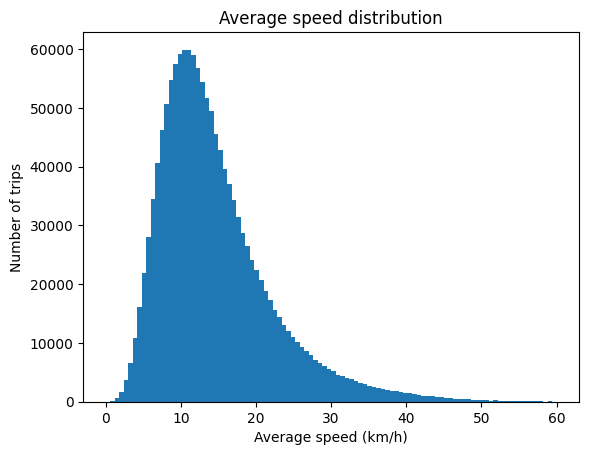

In [57]:
# Plot the average speed, so we can see the distribution, also have a threshold
df['avg_speed'].plot(kind='hist', bins=100, range=(0, 60))
plt.xlabel('Average speed (km/h)')
plt.ylabel('Number of trips')
plt.title('Average speed distribution')
plt.show()


This histogram represents the average speed distribution for taxi trips. Most trips have an average speed between 5 and 20 km/h, with a peak around 10 km/h, indicating the typical speed of taxi trips within an urban area like New York City. There’s a gradual decline in frequency as speed increases, and a very small number of trips with speeds exceeding 40 km/h, which could potentially be outliers.

Justification for Cleaning Based on Average Speed:
Typical Speeds:

The majority of taxi trips seem to have an average speed between 5 and 20 km/h, which aligns with expected urban driving conditions (due to traffic, signals, and frequent stops).
Trips with speeds under 1 km/h are highly improbable and might indicate errors in data capture or extremely short trips that skew the results.
Speeds exceeding 50 km/h seem to be extremely rare in this dataset, which suggests that such high-speed trips are potential outliers or represent trips that took place on highways.
Filtering Extremes:

Given the distribution, a reasonable upper threshold for speed could be 50 km/h to remove outliers that are far from typical urban driving speeds.
A lower threshold of 1 km/h helps to exclude trips where the speed is unrealistic for a typical trip (likely data capture issues).

In [58]:
# Average speed threshold
df = df[(df['avg_speed'] < 60) & (df['avg_speed'] > 5)]

In [59]:
# Inspect cleaned data
print(df.describe())

          vendor_id                pickup_datetime  \
count  1.359022e+06                        1359022   
mean   1.534495e+00  2016-04-01 03:17:27.206607104   
min    1.000000e+00            2016-01-01 00:00:17   
25%    1.000000e+00     2016-02-17 12:44:51.500000   
50%    2.000000e+00            2016-04-01 07:02:41   
75%    2.000000e+00  2016-05-14 21:08:36.249999872   
max    2.000000e+00            2016-06-30 23:59:39   
std    4.988088e-01                            NaN   

                    dropoff_datetime  passenger_count  pickup_longitude  \
count                        1359022     1.359022e+06      1.359022e+06   
mean   2016-04-01 03:31:29.809468160     1.664331e+00     -7.397338e+01   
min              2016-01-01 00:05:54     0.000000e+00     -7.433240e+01   
25%    2016-02-17 12:58:19.249999872     1.000000e+00     -7.399194e+01   
50%       2016-04-01 07:12:55.500000     1.000000e+00     -7.398177e+01   
75%       2016-05-14 21:24:32.500000     2.000000e+00     -7.39